In [67]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style('darkgrid')
from collections import Counter
from imblearn.over_sampling import SMOTE

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))


In [68]:
!pwd

/home/yon/Documents/Personal_Plan/Project_3_ChurnRatePrediction/projectChurnRate


# 1. Dataset 
Dataset source: https://github.com/Paritoshyadav/Minimizing-Churn-Rate-Through-Analysis-of-Financial-Habits



## Dataset:

In [69]:
# Loading the data

dfChurnBank = pd.read_csv('../projectChurnRate/Data/finance_data.csv', index_col=0)

print("Size of the dataset:  %d" % dfChurnBank.shape[0])
print("Number of variables: %d" % dfChurnBank.shape[1])

if dfChurnBank.index.is_unique:
    print('Indexes are unique.')
else:
    print('There are duplicated indexes.')
    
dfChurnBank.head()

Size of the dataset:  27000
Number of variables: 30
There are duplicated indexes.


,churn,age,housing,credit_score,deposits,withdrawal,purchases_partners,purchases,cc_taken,cc_recommended,...,waiting_4_loan,cancelled_loan,received_loan,rejected_loan,zodiac_sign,left_for_two_month_plus,left_for_one_month,rewards_earned,reward_rate,is_referred
user,,,,,,,,,,,,,,,,,,,,,
55409,0,37.0,na,NaN,0,0,0,0,0,0,...,0,0,0,0,Leo,1,0,NaN,0.00,0
23547,0,28.0,R,486.0,0,0,1,0,0,96,...,0,0,0,0,Leo,0,0,44.0,1.47,1
58313,0,35.0,R,561.0,47,2,86,47,0,285,...,0,0,0,0,Capricorn,1,0,65.0,2.17,0
8095,0,26.0,R,567.0,26,3,38,25,0,74,...,0,0,0,0,Capricorn,0,0,33.0,1.10,1
61353,1,27.0,na,NaN,0,0,2,0,0,0,...,0,0,0,0,Aries,1,0,1.0,0.03,0


In [70]:
# Split dataset for modeling and predicting

trainLen = int(len(dfChurnBank)*0.8)
dfChurnBank = dfChurnBank.sample(frac=1, random_state=0)
df = dfChurnBank.iloc[:trainLen].copy()
df_pred = dfChurnBank.iloc[trainLen:].copy()
print('Size of dataset for modeling is {}'.format(len(df)))
print('Size of dataset for prediction is {}'.format(len(df_pred)))

Size of dataset for modeling is 21600
Size of dataset for prediction is 5400


# 3. Pre-processing

1. Remove Null/Nan values
2. Remove duplicated indexes
3. Remove not useful features: app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns
4. Update numerical and categorical values list for modeling
5. Remove outliers
6. Num-Val: Standarize data for training(without binary features)
7. Cat-Val: One hot encoding
8. Create pre-process pipeline function for next preprocesing for test data.

In [71]:
print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head()

Size of the dataset:  21600
Number of variables: 30


,churn,age,housing,credit_score,deposits,withdrawal,purchases_partners,purchases,cc_taken,cc_recommended,...,waiting_4_loan,cancelled_loan,received_loan,rejected_loan,zodiac_sign,left_for_two_month_plus,left_for_one_month,rewards_earned,reward_rate,is_referred
user,,,,,,,,,,,,,,,,,,,,,
50488,0,20.0,R,375.0,0,0,29,0,0,56,...,0,0,0,0,Virgo,0,0,11.0,0.44,1
53603,0,38.0,na,544.0,16,1,28,15,0,41,...,0,0,0,0,Sagittarius,0,0,20.0,0.67,1
42289,1,40.0,R,566.0,0,0,119,0,0,218,...,0,0,0,0,Aries,0,0,19.0,0.63,1
4185,0,34.0,na,547.0,0,0,0,0,0,196,...,0,0,0,0,Scorpio,0,0,62.0,2.07,0
12436,1,24.0,O,488.0,0,0,38,0,0,78,...,0,0,0,0,Scorpio,0,0,22.0,0.73,1


We create a pipeline_preprocess list in order to store all pre-process functions in order to apply later to the prediction dataset.

In [72]:
# Pipeline for pre-preocessing
pipeline_preprocess = []


## 1. Remove Null and Nan values

In [73]:
null_finder = df.isnull().sum()
print(" ***** Number of Null Values by row: ***** ")
null_finder.where(null_finder > 0).dropna()

 ***** Number of Null Values by row: ***** 


age                  4.0
credit_score      6436.0
rewards_earned    2569.0
dtype: float64

In [74]:
def dropnull(df):
    print("Removing columns credit_score and rewards_earned ...(1)")
    df = df.drop(columns=['credit_score','rewards_earned'])
    print("Drop null values from age column ...(2)")
    df = df[pd.notnull(df['age'])]
    return df

df = dropnull(df)

null_finder = df.isnull().sum()
print(" ***** Number of Null Values by row: ***** ")
null_finder.where(null_finder > 0).dropna()


Removing columns credit_score and rewards_earned ...(1)
Drop null values from age column ...(2)
 ***** Number of Null Values by row: ***** 


Series([], dtype: float64)

In [75]:
print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head(10)

Size of the dataset:  21596
Number of variables: 28


,churn,age,housing,deposits,withdrawal,purchases_partners,purchases,cc_taken,cc_recommended,cc_disliked,...,payment_type,waiting_4_loan,cancelled_loan,received_loan,rejected_loan,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
user,,,,,,,,,,,,,,,,,,,,,
50488,0,20.0,R,0,0,29,0,0,56,0,...,Bi-Weekly,0,0,0,0,Virgo,0,0,0.44,1
53603,0,38.0,na,16,1,28,15,0,41,0,...,Monthly,0,0,0,0,Sagittarius,0,0,0.67,1
42289,1,40.0,R,0,0,119,0,0,218,0,...,na,0,0,0,0,Aries,0,0,0.63,1
4185,0,34.0,na,0,0,0,0,0,196,0,...,Bi-Weekly,0,0,0,0,Scorpio,0,0,2.07,0
12436,1,24.0,O,0,0,38,0,0,78,0,...,Weekly,0,0,0,0,Scorpio,0,0,0.73,1
19988,0,25.0,R,0,0,0,0,2,207,1,...,Weekly,0,0,0,0,Cancer,0,0,2.00,1
17437,0,52.0,R,0,0,0,0,0,229,0,...,Bi-Weekly,0,0,0,0,Pisces,1,0,2.20,0
5743,1,27.0,O,0,0,0,0,0,288,0,...,Bi-Weekly,0,0,0,0,na,0,0,2.63,0
22154,1,39.0,R,0,0,6,0,0,69,0,...,Monthly,0,0,0,0,Capricorn,0,0,0.57,1


In [76]:
# Adding to pre-preocessing pipeline:

pipeline_preprocess.append(dropnull)

## 2. Remove duplicated indexes

In [77]:
if df.index.is_unique:
    print('Indexes are unique.')
else:
    print('There are duplicated indexes.')

There are duplicated indexes.


In [78]:
# This function will be agregated to the pre-precessing pipeline:
def dropduplicated(df):
    if df.index.is_unique:
        print('Indexes are unique.')
        return df
    else:
        print('There are duplicated indexes....So removing duplicated indexes ...(3)')
        return df[~df.index.duplicated(keep='first')]

df = dropduplicated(df)


if df.index.is_unique:
    print('Indexes are unique.')
else:
    print('There are duplicated indexes.')

print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head(10)

There are duplicated indexes....So removing duplicated indexes ...(3)
Indexes are unique.
Size of the dataset:  20095
Number of variables: 28


,churn,age,housing,deposits,withdrawal,purchases_partners,purchases,cc_taken,cc_recommended,cc_disliked,...,payment_type,waiting_4_loan,cancelled_loan,received_loan,rejected_loan,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
user,,,,,,,,,,,,,,,,,,,,,
50488,0,20.0,R,0,0,29,0,0,56,0,...,Bi-Weekly,0,0,0,0,Virgo,0,0,0.44,1
53603,0,38.0,na,16,1,28,15,0,41,0,...,Monthly,0,0,0,0,Sagittarius,0,0,0.67,1
42289,1,40.0,R,0,0,119,0,0,218,0,...,na,0,0,0,0,Aries,0,0,0.63,1
4185,0,34.0,na,0,0,0,0,0,196,0,...,Bi-Weekly,0,0,0,0,Scorpio,0,0,2.07,0
12436,1,24.0,O,0,0,38,0,0,78,0,...,Weekly,0,0,0,0,Scorpio,0,0,0.73,1
19988,0,25.0,R,0,0,0,0,2,207,1,...,Weekly,0,0,0,0,Cancer,0,0,2.00,1
17437,0,52.0,R,0,0,0,0,0,229,0,...,Bi-Weekly,0,0,0,0,Pisces,1,0,2.20,0
5743,1,27.0,O,0,0,0,0,0,288,0,...,Bi-Weekly,0,0,0,0,na,0,0,2.63,0
22154,1,39.0,R,0,0,6,0,0,69,0,...,Monthly,0,0,0,0,Capricorn,0,0,0.57,1


In [79]:
# Adding to pre-preocessing pipeline:

pipeline_preprocess.append(dropduplicated)

## 3. Remove app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns

In [80]:
# Remove app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns

def dropcolumns(df):
    print("Drop app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns ...(4)")
    df = df.drop(columns=['app_web_user','deposits', 'ios_user','cc_recommended', 'cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan',
                          'withdrawal', 'purchases', 'cc_taken', 'cc_disliked', 'cc_liked', 'registered_phones'])
    return df
df = dropcolumns(df)

print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head(10)


Drop app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns ...(4)
Size of the dataset:  20095
Number of variables: 14


,churn,age,housing,purchases_partners,cc_application_begin,app_downloaded,web_user,android_user,payment_type,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
user,,,,,,,,,,,,,,
50488,0,20.0,R,29,8,1,0,1,Bi-Weekly,Virgo,0,0,0.44,1
53603,0,38.0,na,28,5,1,0,1,Monthly,Sagittarius,0,0,0.67,1
42289,1,40.0,R,119,29,1,1,1,na,Aries,0,0,0.63,1
4185,0,34.0,na,0,71,1,1,0,Bi-Weekly,Scorpio,0,0,2.07,0
12436,1,24.0,O,38,7,1,1,1,Weekly,Scorpio,0,0,0.73,1
19988,0,25.0,R,0,7,1,1,1,Weekly,Cancer,0,0,2.00,1
17437,0,52.0,R,0,38,1,1,1,Bi-Weekly,Pisces,1,0,2.20,0
5743,1,27.0,O,0,12,1,0,1,Bi-Weekly,na,0,0,2.63,0
22154,1,39.0,R,6,3,1,1,1,Monthly,Capricorn,0,0,0.57,1


In [81]:
# Adding to pre-preocessing pipeline:

pipeline_preprocess.append(dropcolumns)

## 4. Update numerical and categorical values list for modeling 

In [82]:
# Update numerical and categorical values for later modeling

cat_features = df.select_dtypes(exclude = np.number).columns
num_features = df.select_dtypes(include = np.number).columns
print( "Quantity of Categorical features: ", len(cat_features),"\nCategorical features: ", cat_features)
print( "\nQuantity of Numerical features: ", len(num_features),"\nNumerical features: ", num_features)

Quantity of Categorical features:  3 
Categorical features:  Index(['housing', 'payment_type', 'zodiac_sign'], dtype='object')

Quantity of Numerical features:  11 
Numerical features:  Index(['churn', 'age', 'purchases_partners', 'cc_application_begin',
       'app_downloaded', 'web_user', 'android_user', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred'],
      dtype='object')


In [83]:
# Quantity of numerical values:

num_features_new = list(filter(lambda col: len(df[col].value_counts()) > 2, df.select_dtypes(include = np.number).columns))
num_features_bin = list(filter(lambda col: len(df[col].value_counts()) == 2, df.select_dtypes(include = np.number).columns))

print("Quantity of features greater than 2:", len(num_features_new))
print(num_features_new)
print()
print("Quantity of features equal to 2(binary):", len(num_features_bin))
print(num_features_bin)

Quantity of features greater than 2: 4
['age', 'purchases_partners', 'cc_application_begin', 'reward_rate']

Quantity of features equal to 2(binary): 7
['churn', 'app_downloaded', 'web_user', 'android_user', 'left_for_two_month_plus', 'left_for_one_month', 'is_referred']


## 5. Remove outliers

For removeing outliers, we focus on numerical features which are not binary.

In [84]:
# Detecting outliers
def detect_outlier(d):
    """
    df: dataframe
    """

    for col in num_features_new: 
        first_q = np.percentile(df[col], 25)
        third_q = np.percentile(df[col], 75) 
        IQR = 1.5*(third_q - first_q)
        minimum = first_q - IQR 
        maximum = third_q + IQR
        
        if(minimum > np.min(df[col]) or maximum < np.max(df[col])):
            print(col, "There is Outlier")
            
# Removing outliers
def remove_outlier(df):
    """
    df: dataframe
    """
    
    num_features_new = list(filter(lambda col: len(df[col].value_counts()) > 2, df.select_dtypes(include = np.number).columns))
    outliers = []
    for col in num_features_new:
        first_q = np.percentile(df[col], 25)
        third_q = np.percentile(df[col], 75) 
        IQR = 1.5*(third_q - first_q)
        minimum = first_q - IQR 
        maximum = third_q + IQR
        
        if(minimum > np.min(df[col]) or maximum < np.max(df[col])):
            outliers.append(col)
    print("The outliers are :", outliers)
    
    print("Removing outliers ...(5)")
    for col in outliers:
        first_q = np.percentile(df[col], 25)
        third_q = np.percentile(df[col], 75) 
        IQR = 1.5*(third_q - first_q)
        minimum = first_q - IQR 
        maximum = third_q + IQR
    
        median = df[col].median()
    
        df.loc[df[col] < minimum, col] = median 
        df.loc[df[col] > maximum, col] = median
    return df

In [85]:
detect_outlier(df[num_features_new])

age There is Outlier
purchases_partners There is Outlier
cc_application_begin There is Outlier
reward_rate There is Outlier


In [86]:
df = remove_outlier(df)

print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head(10)

The outliers are : ['age', 'purchases_partners', 'cc_application_begin', 'reward_rate']
Removing outliers ...(5)
Size of the dataset:  20095
Number of variables: 14


,churn,age,housing,purchases_partners,cc_application_begin,app_downloaded,web_user,android_user,payment_type,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
user,,,,,,,,,,,,,,
50488,0,20.0,R,29,8,1,0,1,Bi-Weekly,Virgo,0,0,0.44,1
53603,0,38.0,na,28,5,1,0,1,Monthly,Sagittarius,0,0,0.67,1
42289,1,40.0,R,8,4,1,1,1,na,Aries,0,0,0.63,1
4185,0,34.0,na,0,4,1,1,0,Bi-Weekly,Scorpio,0,0,2.07,0
12436,1,24.0,O,38,7,1,1,1,Weekly,Scorpio,0,0,0.73,1
19988,0,25.0,R,0,7,1,1,1,Weekly,Cancer,0,0,2.00,1
17437,0,52.0,R,0,4,1,1,1,Bi-Weekly,Pisces,1,0,2.20,0
5743,1,27.0,O,0,12,1,0,1,Bi-Weekly,na,0,0,2.63,0
22154,1,39.0,R,6,3,1,1,1,Monthly,Capricorn,0,0,0.57,1


In [87]:
# Adding to pre-preocessing pipeline:

pipeline_preprocess.append(remove_outlier)

<AxesSubplot:>

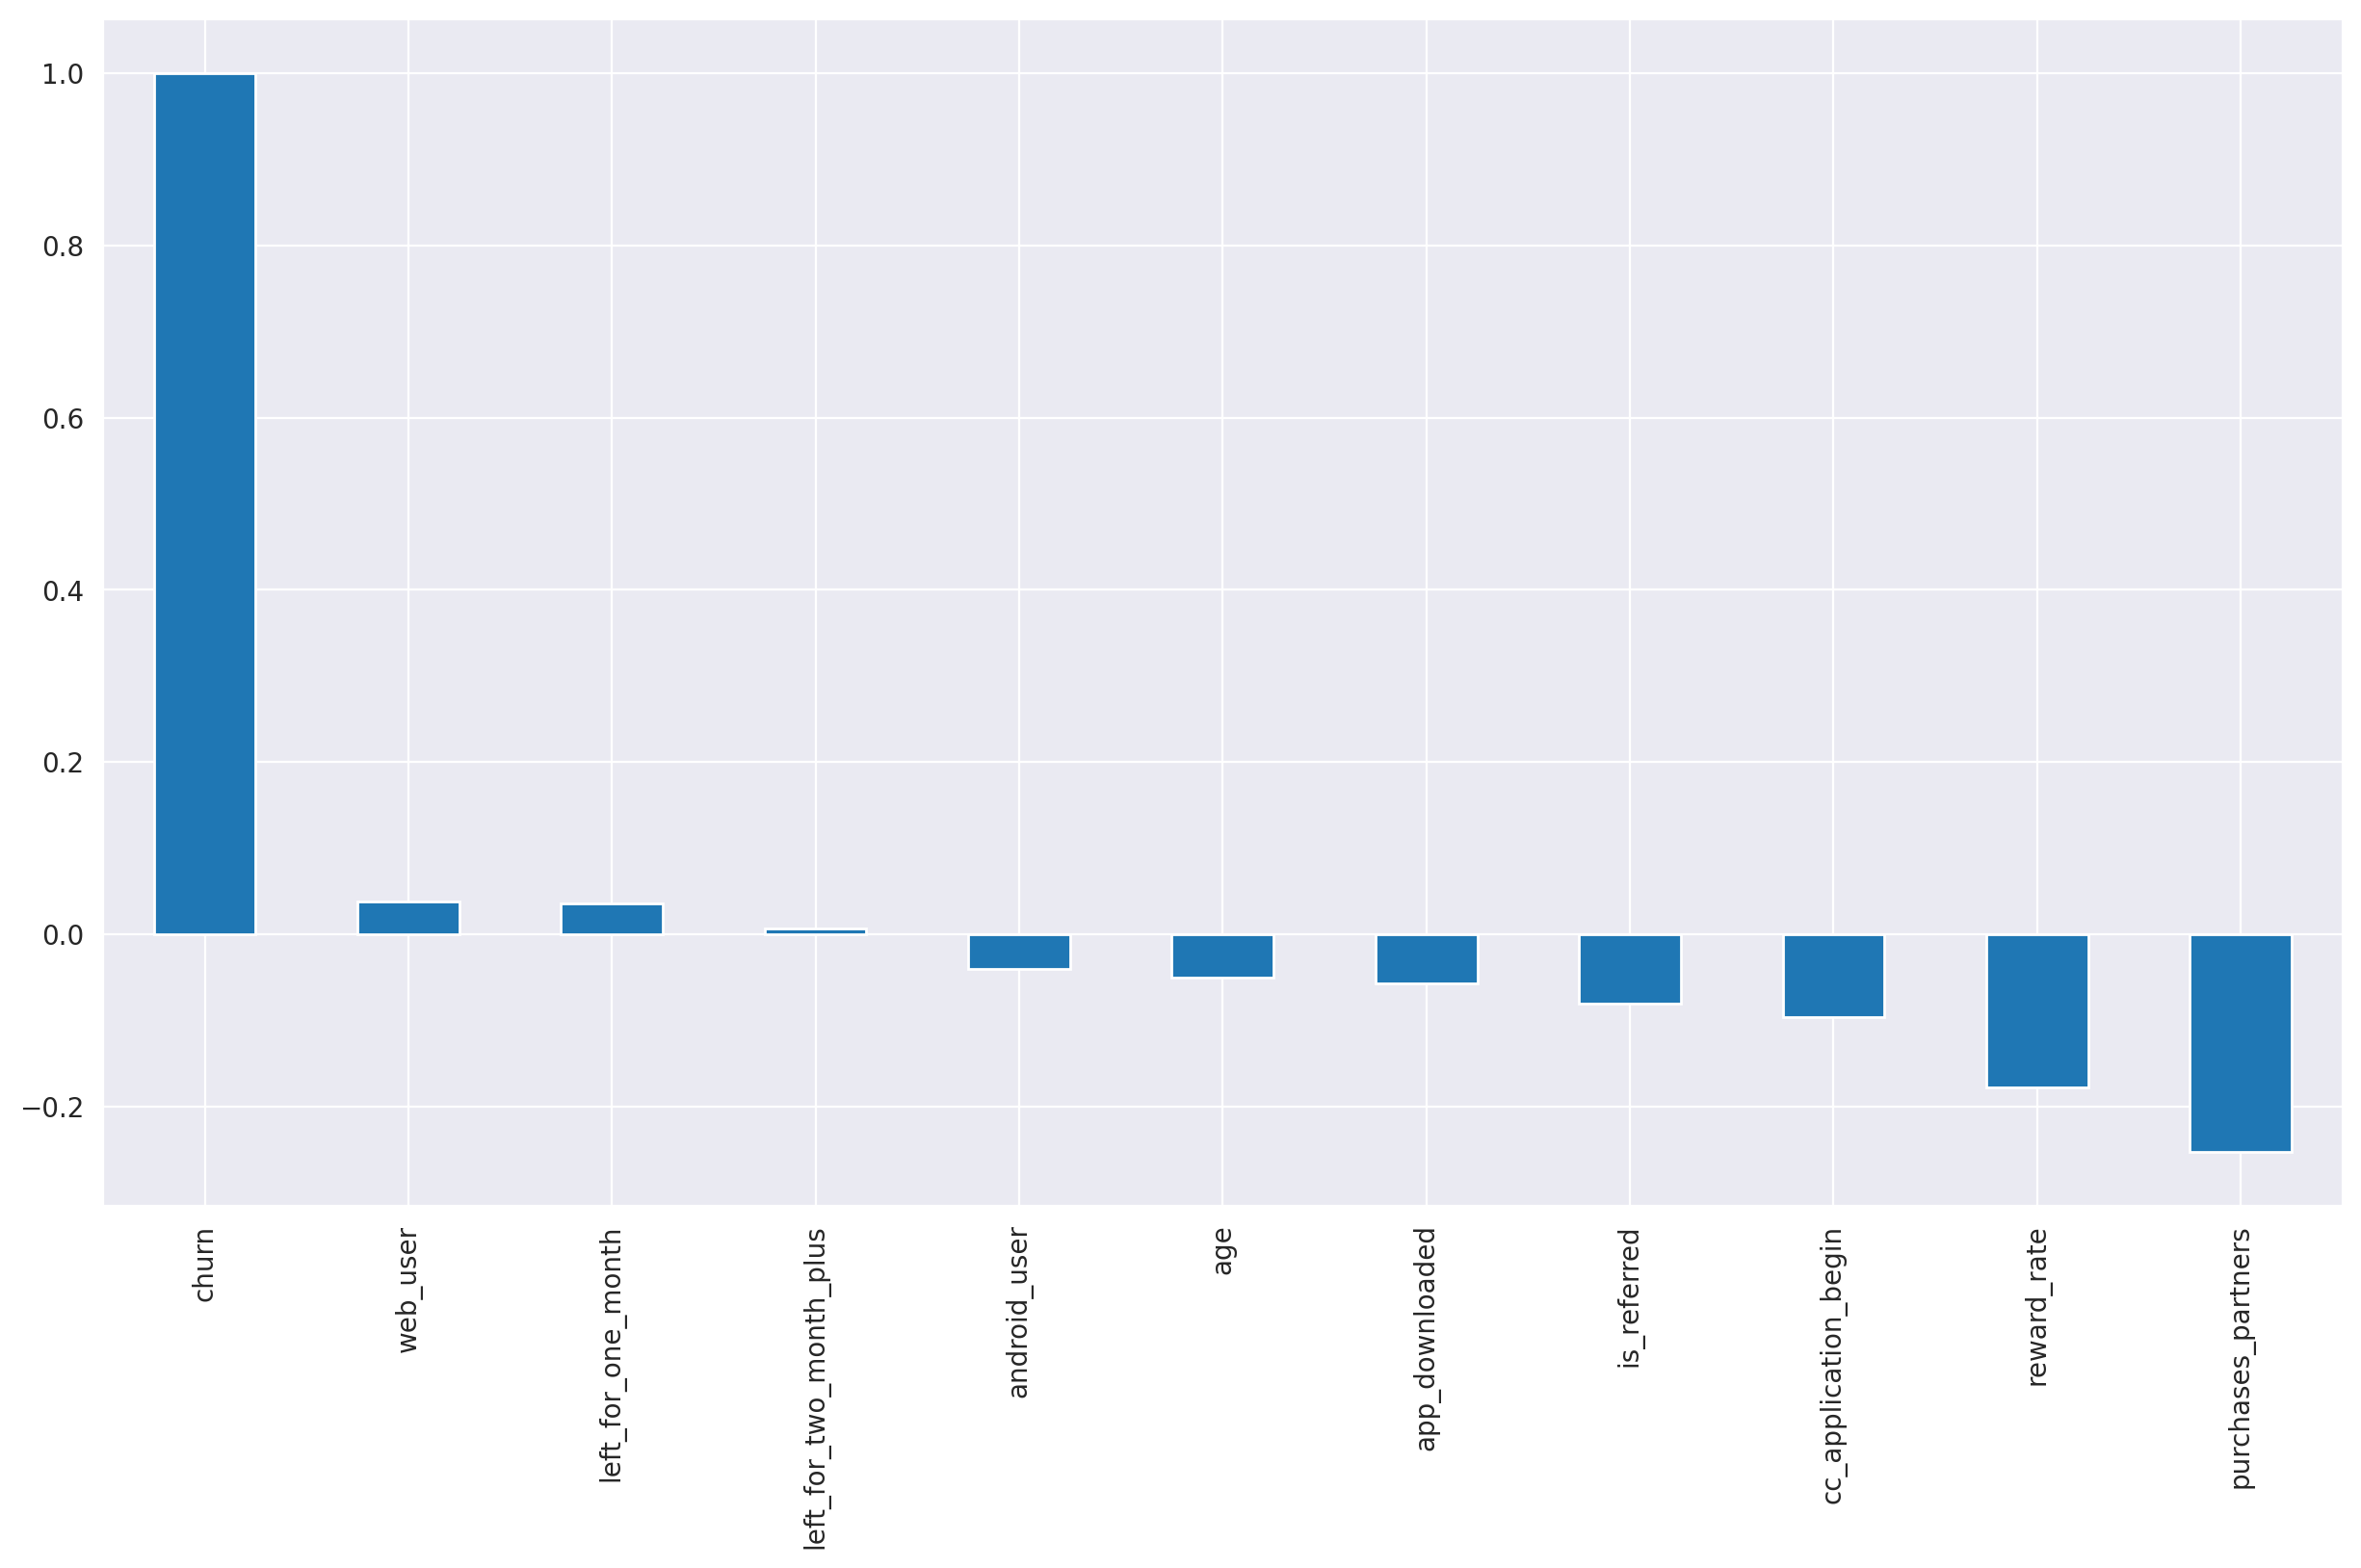

In [88]:
plt.figure(figsize=(15,8))
df[num_features].corr()['churn'].sort_values(ascending = False).plot(kind='bar')

## 6. Num-Val: Standarize data for training(without binary features)

In [89]:
def standardizeNum(df):
    standardize = StandardScaler()
    num_features = df.select_dtypes(include = np.number).columns
    num_features_new = list(filter(lambda col: len(df[col].value_counts()) > 2, num_features))
    print("Standarizing Numerical variables ...(6)")
    df[num_features_new] = standardize.fit_transform(df[num_features_new])
    return df


In [90]:
df = standardizeNum(df)
print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head(10)

Standarizing Numerical variables ...(6)
Size of the dataset:  20095
Number of variables: 14


,churn,age,housing,purchases_partners,cc_application_begin,app_downloaded,web_user,android_user,payment_type,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
user,,,,,,,,,,,,,,
50488,0,-1.343601,R,0.337098,0.363497,1,0,1,Bi-Weekly,Virgo,0,0,-0.617441,1
53603,0,0.824089,na,0.299623,-0.096405,1,0,1,Monthly,Sagittarius,0,0,-0.307211,1
42289,1,1.064943,R,-0.449882,-0.249706,1,1,1,na,Aries,0,0,-0.361164,1
4185,0,0.342380,na,-0.749683,-0.249706,1,1,0,Bi-Weekly,Scorpio,0,0,1.581146,0
12436,1,-0.861892,O,0.674375,0.210196,1,1,1,Weekly,Scorpio,0,0,-0.226281,1
19988,0,-0.741465,R,-0.749683,0.210196,1,1,1,Weekly,Cancer,0,0,1.486728,1
17437,0,2.510070,R,-0.749683,-0.249706,1,1,1,Bi-Weekly,Pisces,1,0,1.756493,0
5743,1,-0.500610,O,-0.749683,0.976700,1,0,1,Bi-Weekly,na,0,0,2.336488,0
22154,1,0.944516,R,-0.524832,-0.403007,1,1,1,Monthly,Capricorn,0,0,-0.442093,1


In [91]:
# Adding to pre-preocessing pipeline:

pipeline_preprocess.append(standardizeNum)

## 7. Cat-Val: One hot encoding

In [92]:
def removedummy(df):
    print("Convert categorical values into numbers ...(7)")
    df_new = pd.get_dummies(df)
    print("Remove Categorical Variables housing_na, zodiac_sign_na, payment_type_na ...(8)")
    df_new = df_new.drop(columns = ['housing_na', 'zodiac_sign_na', 'payment_type_na'])
    return df_new


In [93]:
df = removedummy(df)
print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head(10)

Convert categorical values into numbers ...(7)
Remove Categorical Variables housing_na, zodiac_sign_na, payment_type_na ...(8)
Size of the dataset:  20095
Number of variables: 29


,churn,age,purchases_partners,cc_application_begin,app_downloaded,web_user,android_user,left_for_two_month_plus,left_for_one_month,reward_rate,...,zodiac_sign_Cancer,zodiac_sign_Capricorn,zodiac_sign_Gemini,zodiac_sign_Leo,zodiac_sign_Libra,zodiac_sign_Pisces,zodiac_sign_Sagittarius,zodiac_sign_Scorpio,zodiac_sign_Taurus,zodiac_sign_Virgo
user,,,,,,,,,,,,,,,,,,,,,
50488,0,-1.343601,0.337098,0.363497,1,0,1,0,0,-0.617441,...,0,0,0,0,0,0,0,0,0,1
53603,0,0.824089,0.299623,-0.096405,1,0,1,0,0,-0.307211,...,0,0,0,0,0,0,1,0,0,0
42289,1,1.064943,-0.449882,-0.249706,1,1,1,0,0,-0.361164,...,0,0,0,0,0,0,0,0,0,0
4185,0,0.342380,-0.749683,-0.249706,1,1,0,0,0,1.581146,...,0,0,0,0,0,0,0,1,0,0
12436,1,-0.861892,0.674375,0.210196,1,1,1,0,0,-0.226281,...,0,0,0,0,0,0,0,1,0,0
19988,0,-0.741465,-0.749683,0.210196,1,1,1,0,0,1.486728,...,1,0,0,0,0,0,0,0,0,0
17437,0,2.510070,-0.749683,-0.249706,1,1,1,1,0,1.756493,...,0,0,0,0,0,1,0,0,0,0
5743,1,-0.500610,-0.749683,0.976700,1,0,1,0,0,2.336488,...,0,0,0,0,0,0,0,0,0,0
22154,1,0.944516,-0.524832,-0.403007,1,1,1,0,0,-0.442093,...,0,1,0,0,0,0,0,0,0,0


In [94]:
# Adding to pre-preocessing pipeline:

pipeline_preprocess.append(removedummy)

## 8. Create pre-processing pipeline

In [95]:
print("\nSteps for pre-processing: ")
for step, function in enumerate(pipeline_preprocess):
    print("\t {:d}: {:s}".format(step, function.__name__))


Steps for pre-processing: 
	 0: dropnull
	 1: dropduplicated
	 2: dropcolumns
	 3: remove_outlier
	 4: standardizeNum
	 5: removedummy


In [96]:
# Definition of preprocess_data for an specific dataset:

def preprocess_data_pipeline(df, pipeline_preprocess):
    for step, function in enumerate(pipeline_preprocess):
        df = function(df)
    print("Size of the dataset:  %d" % df.shape[0])
    print("Number of variables: %d" % df.shape[1])
    df.head(10)
    return df

Testing the preprocess_data_pipeline function for new data:

In [97]:
df_aux = pd.read_csv('../projectChurnRate/Data/finance_data.csv', index_col=0).sample(n=2100, random_state=0)
preprocess_data_pipeline(df_aux, pipeline_preprocess)

Removing columns credit_score and rewards_earned ...(1)
Drop null values from age column ...(2)
There are duplicated indexes....So removing duplicated indexes ...(3)
Drop app_web_user, deposit, ios_user, cc_recommended, cancelled_loan', 'received_loan', 'rejected_loan', 'waiting_4_loan' columns ...(4)
The outliers are : ['age', 'purchases_partners', 'cc_application_begin', 'reward_rate']
Removing outliers ...(5)
Standarizing Numerical variables ...(6)
Convert categorical values into numbers ...(7)
Remove Categorical Variables housing_na, zodiac_sign_na, payment_type_na ...(8)
Size of the dataset:  2086
Number of variables: 29


,churn,age,purchases_partners,cc_application_begin,app_downloaded,web_user,android_user,left_for_two_month_plus,left_for_one_month,reward_rate,...,zodiac_sign_Cancer,zodiac_sign_Capricorn,zodiac_sign_Gemini,zodiac_sign_Leo,zodiac_sign_Libra,zodiac_sign_Pisces,zodiac_sign_Sagittarius,zodiac_sign_Scorpio,zodiac_sign_Taurus,zodiac_sign_Virgo
user,,,,,,,,,,,,,,,,,,,,,
50488,0,-1.370706,0.297870,0.366173,1,0,1,0,0,-0.617316,...,0,0,0,0,0,0,0,0,0,1
53603,0,0.830067,0.260902,-0.093048,1,0,1,0,0,-0.302837,...,0,0,0,0,0,0,1,0,0,0
42289,1,1.074597,-0.441489,-0.246121,1,1,1,0,0,-0.357529,...,0,0,0,0,0,0,0,0,0,0
4185,0,0.341006,-0.774201,-0.246121,1,1,0,0,0,1.611379,...,0,0,0,0,0,0,0,1,0,0
12436,1,-0.881646,0.630582,0.213100,1,1,1,0,0,-0.220799,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23350,1,-1.126176,0.371806,0.213100,1,1,1,1,0,-1.218926,...,0,0,0,0,0,0,0,0,0,1
53737,0,1.441393,0.076063,-0.705343,1,1,0,0,0,-0.535278,...,0,0,1,0,0,0,0,0,0,0
56724,1,1.074597,-0.774201,-0.858416,1,1,0,0,0,-0.808737,...,0,0,0,0,0,0,0,0,1,0


In [34]:
df.to_csv('./Data/df_preprocess_done.csv')
df_pred.to_csv('./Data/df_prediction.csv')